In [1]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.sql.functions import stddev_pop, avg,stddev
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Matrices
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [3]:
#Data = pd.read_csv("https://github.com/bigdata-i523/hid328/blob/master/project/data/german_credit.csv")
Data = pd.read_csv("../data/credit_data.csv")

In [4]:
Data.head(10)

,Creditability,Account_Balance,Duration_of_Credit,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,good,-1,6,critical/other existing credit,radio/tv,1169,no known savings,15,47,male single,...,4,real estate,67,none,own,2,skilled,1,yes,yes
1,bad,13,48,existing paid,radio/tv,5951,10,3,25,female div/dep/mar,...,2,real estate,22,none,own,1,skilled,1,none,yes
2,good,no checking,12,critical/other existing credit,education,2096,75,4,29,male single,...,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,good,-1,42,existing paid,furniture/equipment,7882,1,4,34,male single,...,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,bad,-1,24,delayed previously,new car,4870,60,2,21,male single,...,4,no known property,53,none,for free,2,skilled,2,none,yes
5,good,no checking,36,existing paid,education,9055,no known savings,1,34,male single,...,4,no known property,35,none,for free,1,unskilled resident,2,yes,yes
6,good,no checking,24,existing paid,furniture/equipment,2835,693,17,20,male single,...,4,life insurance,53,none,own,1,skilled,1,none,yes
7,good,65,36,existing paid,used car,6948,83,2,29,male single,...,2,car,35,none,rent,1,high qualif/self emp/mgmt,1,yes,yes
8,good,no checking,12,existing paid,radio/tv,3059,2447,6,30,male div/sep,...,4,real estate,61,none,own,1,unskilled resident,1,none,yes
9,bad,41,30,critical/other existing credit,new car,5234,67,unemployed,6,male mar/wid,...,2,car,28,none,own,2,high qualif/self emp/mgmt,1,none,yes


In [5]:
%matplotlib inline
sn.set(color_codes=True)

In [6]:

spark = SparkSession.builder.appName("analytics").master("local").getOrCreate()
csvDF = spark.read.format("csv").option("header","true").option("inferSchema", "true").load("../data/german_credit.csv")

In [7]:
csvPandas=csvDF.toPandas()

In [8]:
csvPandas.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


Text(0,0.5,u'Frequency')

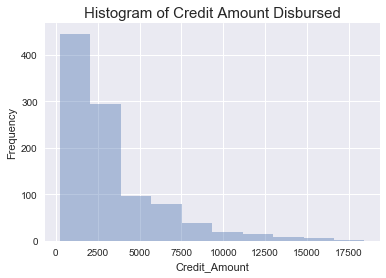

In [9]:
sn.distplot(csvPandas.Credit_Amount, kde = False,bins=10 )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")


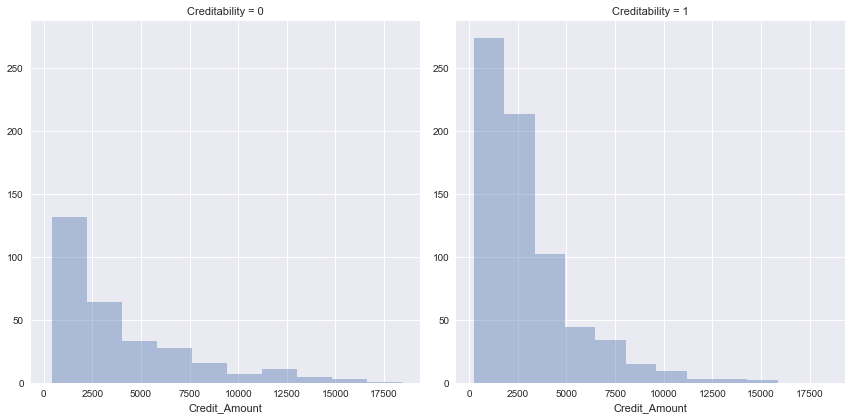

In [10]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Credit_Amount", kde = False, bins = 10 )

Text(0,0.5,u'Frequency')

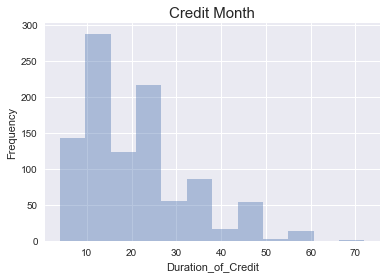

In [11]:
sn.distplot(csvPandas.Duration_of_Credit, kde = False,bins=12)
plt.title( "Credit Month", fontsize = 15)
plt.ylabel( "Frequency")

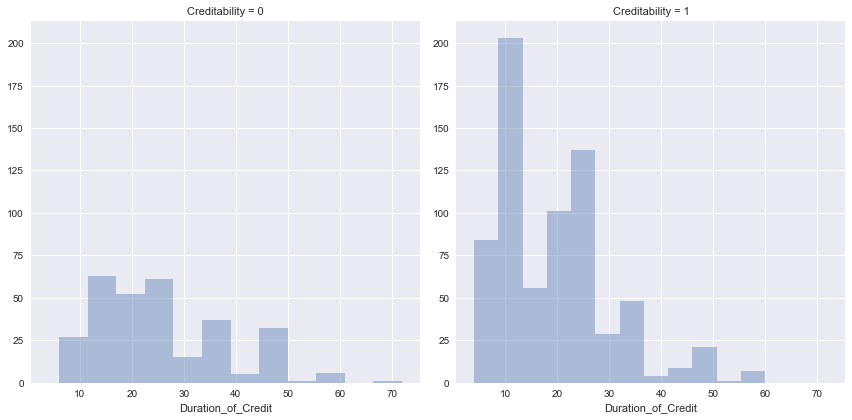

In [12]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Duration_of_Credit", kde = False, bins = 12)

Text(0,0.5,u'Frequency')

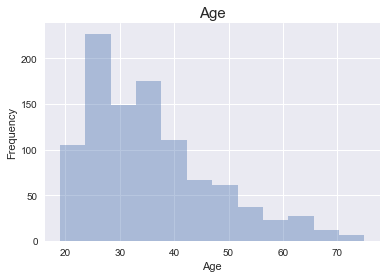

In [65]:
sn.distplot(csvPandas.Age, kde = False,bins=12)
plt.title( "Age", fontsize = 15)
plt.ylabel( "Frequency")

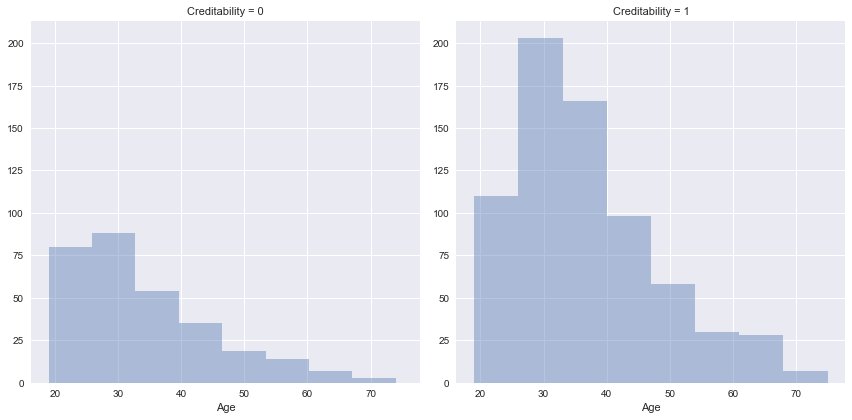

In [66]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Age", kde = False, bins = 8)

In [67]:
csvDF.select("Creditability").groupBy("Creditability").count().show()

+-------------+-----+
|Creditability|count|
+-------------+-----+
|            1|  700|
|            0|  300|
+-------------+-----+



In [68]:
rows=[]
rows.append((csvPandas['Credit_Amount'].min(),csvPandas.Credit_Amount.quantile(.25),csvPandas['Credit_Amount'].median(),csvPandas['Credit_Amount'].mean(),csvPandas.Credit_Amount.quantile(.75),csvPandas['Credit_Amount'].max()))
crAmountPerc = pd.DataFrame(rows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
crAmountPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,250,1365.5,2319.5,3271.248,3972.25,18424


In [69]:
dcrows=[]
dcrows.append((csvPandas['Duration_of_Credit'].min(),csvPandas.Duration_of_Credit.quantile(.25),csvPandas['Duration_of_Credit'].median(),csvPandas['Duration_of_Credit'].mean(),csvPandas.Duration_of_Credit.quantile(.75),csvPandas['Duration_of_Credit'].max()))
dcPerc = pd.DataFrame(dcrows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
dcPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,4,12.0,18.0,20.903,24.0,72


In [70]:
Agerows=[]
Agerows.append((csvPandas['Age'].min(),csvPandas.Age.quantile(.25),csvPandas['Age'].median(),csvPandas['Age'].mean(),csvPandas.Age.quantile(.75),csvPandas['Age'].max()))
agePerc = pd.DataFrame(Agerows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
agePerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,19,27.0,33.0,35.542,42.0,75


In [71]:
data=csvDF.rdd.map(lambda x:(Vectors.dense(x[1:]), float(x[0]))).toDF(["features", "label"])

In [72]:
r = ChiSquareTest.test(data, "features", "label").head()

In [73]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'PValues':r.pValues.values,'Chi^2':r.statistics.values,'D.F':r.degreesOfFreedom})
pdf.head(21)

,All,Chi^2,D.F,PValues
0,Account_Balance,123.720944,3,0.000000e+00
1,Duration_of_Credit,78.886937,32,7.784572e-06
2,Previous_Credit,61.691397,4,1.279199e-12
3,Purpose,33.356447,9,1.157491e-04
4,Credit_Amount,931.746032,922,4.045155e-01
5,Value_Savings_Stocks,36.098928,4,2.761214e-07
6,employment,18.368274,4,1.045452e-03
7,Instalment_percent,5.476792,3,1.400333e-01
8,Sex_MaritalStatus,9.605214,3,2.223801e-02
9,Guarantors,6.645367,2,3.605595e-02


In [74]:
dataPanda = data.toPandas()
dataPanda.head(5)

,features,label
0,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2...",1.0
1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3....",1.0
2,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2....",1.0
3,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3...",1.0
4,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3...",1.0


In [75]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Logistic Regression

In [376]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)

In [377]:
lrEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lrEvaluator.evaluate(predictions)

0.7384105960264901

In [379]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [382]:
predictions = cvModel.transform(testData)
lrEvaluator.evaluate(predictions)
#cvModel.bestModel

0.7350993377483444

In [383]:
cvModel.bestModel.coefficients

DenseVector([0.5315, -0.03, 0.2813, 0.0102, -0.0001, 0.2463, 0.1165, -0.3071, 0.114, 0.0578, -0.1783, -0.3089, 0.0071, 0.0124, 0.0773, -0.0895, -0.0612, -0.3011, 0.2563, -0.2391])

In [384]:
print 'Model Intercept: ', cvModel.bestModel.intercept

Model Intercept:  0.788352163599


# Decision Tree

In [76]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [77]:
dtModel=dt.fit(trainingData)

In [212]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1,2,6,10])
             .addGrid(dt.maxBins, [20,40,80])
             .build())

In [215]:
# Create 5-fold CrossValidator
dtCv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [216]:
dtCvModel = dtCv.fit(trainingData)

In [225]:
print"numNodes = ",dtCvModel.bestModel.numNodes
print"depth = ", dtCvModel.bestModel.depth

numNodes =  7
depth =  2


In [220]:
dtPredictions = dtCvModel.transform(testData)

In [221]:
dtEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dtEvaluator.evaluate(dtPredictions)

0.7119205298013245

In [222]:
dtPredictionsPanda = dtPredictions.toPandas()
dtPredictionsPanda.head(5)

,features,label,rawPrediction,probability,prediction
0,"[1.0, 6.0, 1.0, 6.0, 1198.0, 1.0, 5.0, 4.0, 2....",0.0,"[65.0, 128.0]","[0.336787564767, 0.663212435233]",1.0
1,"[1.0, 6.0, 2.0, 0.0, 662.0, 1.0, 2.0, 3.0, 3.0...",1.0,"[65.0, 128.0]","[0.336787564767, 0.663212435233]",1.0
2,"[1.0, 6.0, 2.0, 0.0, 1203.0, 2.0, 5.0, 3.0, 3....",1.0,"[65.0, 128.0]","[0.336787564767, 0.663212435233]",1.0
3,"[1.0, 6.0, 2.0, 2.0, 428.0, 1.0, 5.0, 2.0, 2.0...",1.0,"[65.0, 128.0]","[0.336787564767, 0.663212435233]",1.0
4,"[1.0, 6.0, 2.0, 2.0, 1374.0, 1.0, 3.0, 1.0, 3....",1.0,"[65.0, 128.0]","[0.336787564767, 0.663212435233]",1.0


In [80]:
def myConcat(*cols):
 return F.concat(*[F.coalesce(c, F.lit("*")) for c in cols])

In [143]:
dtMetricsData = dtPredictions.select("label","prediction")
pandaDtMetrics=dtMetricsData.groupby("label","prediction").count().toPandas()
pivotedDt = pandaDtMetrics.pivot(index='label', columns='prediction', values='count')
pivotedDt.head(5)

prediction,0.0,1.0
label,,
0.0,46,45
1.0,50,161


In [146]:
dtPenalty=pivotedDt.values[0][1]*5+pivotedDt.values[1][0]
print(dtPenalty)

275


# Random Forest

In [31]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingData)

In [33]:
print("number of Classes :"+str(rfModel.numClasses))

number of Classes :2


In [34]:
print("number of Features :"+str(rfModel.numFeatures))

number of Features :20


In [35]:
print("Total number of Nodes :"+str(rfModel.totalNumNodes))

Total number of Nodes :960


In [273]:
print "Max Bins",rf.getMaxBins()

print "Max Trees",rf.getNumTrees()
print "Max Depth",rf.getMaxDepth()

Max Bins 32
Max Trees 20
Max Depth 5


In [241]:

rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

0.7814569536423841

In [323]:
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features")
#rf2Model = rf2.fit(trainingData)

In [356]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [200])
             .build())

In [357]:
rfCv2 = CrossValidator(estimator=rf2, estimatorParamMaps=paramGrid, evaluator=rfEvaluator, numFolds=2)

In [358]:
rfCv2Model = rfCv2.fit(trainingData)

In [359]:
rf2Predictions = rfCv2Model.transform(testData)

In [360]:
rf2Evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


In [361]:
rf2Evaluator.evaluate(rf2Predictions)


0.7019867549668874

In [362]:


print "Max Trees",rfCv2Model.bestModel.getNumTrees


Max Trees 20


In [366]:
bestModel = rfCv2Model.bestModel
finalPredictions = bestModel.transform(data)
rf2Evaluator.evaluate(finalPredictions)

0.807

In [367]:
rf2Predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,6.0,1.0,6.0,...|  0.0|[8.24908989730459...|[0.41245449486522...|       1.0|
|[1.0,6.0,2.0,0.0,...|  1.0|[4.71417944524625...|[0.23570897226231...|       1.0|
|[1.0,6.0,2.0,0.0,...|  1.0|[5.10177776896806...|[0.25508888844840...|       1.0|
|[1.0,6.0,2.0,2.0,...|  1.0|[5.20193921996775...|[0.26009696099838...|       1.0|
|[1.0,6.0,2.0,2.0,...|  1.0|[3.61548380774399...|[0.18077419038719...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [368]:
metricsData = rf2Predictions.select("label","prediction")
sDF=metricsData.groupby("label","prediction").count()
pandaSDF=sDF.toPandas()
df2 = pandaSDF.pivot(index='label', columns='prediction', values='count')
df2.head(5)

prediction,0.0,1.0
label,,
0.0,19,72
1.0,18,193


In [369]:
penalty=df2.values[0][1]*5+df2.values[1][0]
print(penalty)

378


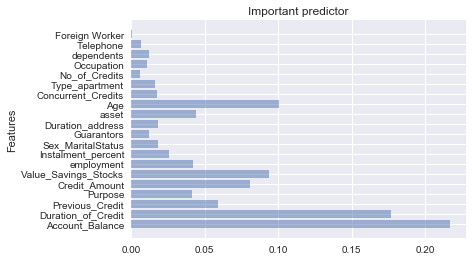

In [372]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'Important':rfModel.featureImportances.values},columns=['All','Important'])
objects = csvDF.columns[1:]
y_pos = np.arange(len(csvDF.columns[1:]))
performance = rfModel.featureImportances.values
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Features')
plt.title('Important predictor')

plt.show()


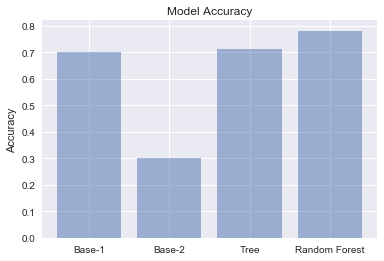

In [373]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [.7,.3,dtEvaluator.evaluate(dtPredictions),evaluator.evaluate(predictions)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
 
plt.show()

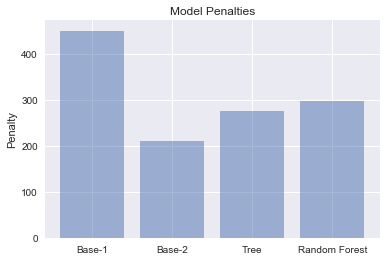

In [147]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [450,210,dtPenalty,penalty]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Penalty')
plt.title('Model Penalties')
 
plt.show()

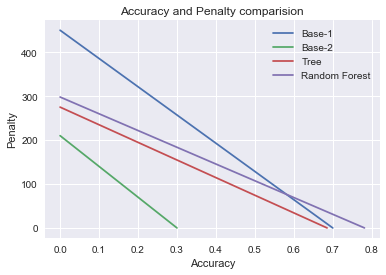

In [211]:

datax1=[.7,.3,dtEvaluator.evaluate(dtPredictions),evaluator.evaluate(predictions)]
datay1=[0,0,0,0]

datax2=[0,0,0,0]
datay2=[450,210,dtPenalty,penalty]
models =['Base-1','Base-2','Tree','Random Forest']

fig,ax = plt.subplots()
for i in range(len(datax1)):
    x = (datax1[i], datax2[i])
    y = (datay1[i], datay2[i]) 
    ax.plot(x, y,label=models[i])
ax.legend()
plt.title("Accuracy and Penalty comparision")
plt.xlabel("Accuracy")
plt.ylabel("Penalty")
plt.show()

